Years (all): [2020, 2021, 2022, 2023, 2024, 2025] | Train backtest: [2020, 2021, 2022, 2023, 2024]
Computing per-image, per-state NDVI means (server-side)…

=== Positive-lag scan (dz_mean vs next-half return, train years) ===
lag=+0: corr=+0.065
lag=+1: corr=+0.052
lag=+2: corr=-0.260
lag=+3: corr=+0.393
lag=+4: corr=-0.443
Chosen non-negative modeling lag: +4

=== Backtest metrics (semi-monthly, 2020–2024) ===
{'NDVI_LagModel_PosOnly': {'CAGR': np.float64(0.223),
                           'HitRate': np.float64(0.4),
                           'MaxDD': -0.1,
                           'Sharpe': np.float64(0.976),
                           'Vol': np.float64(0.232)},
 'Seasonal_BH': {'CAGR': np.float64(-0.412),
                 'HitRate': np.float64(0.2),
                 'MaxDD': -0.466,
                 'Sharpe': np.float64(-1.761),
                 'Vol': np.float64(0.271)}}

=== 2025 Semi-Monthly Trade Suggestions (Apr–Jul) ===
 Year  Month  Half PredictedRet Signal
 2025      6   

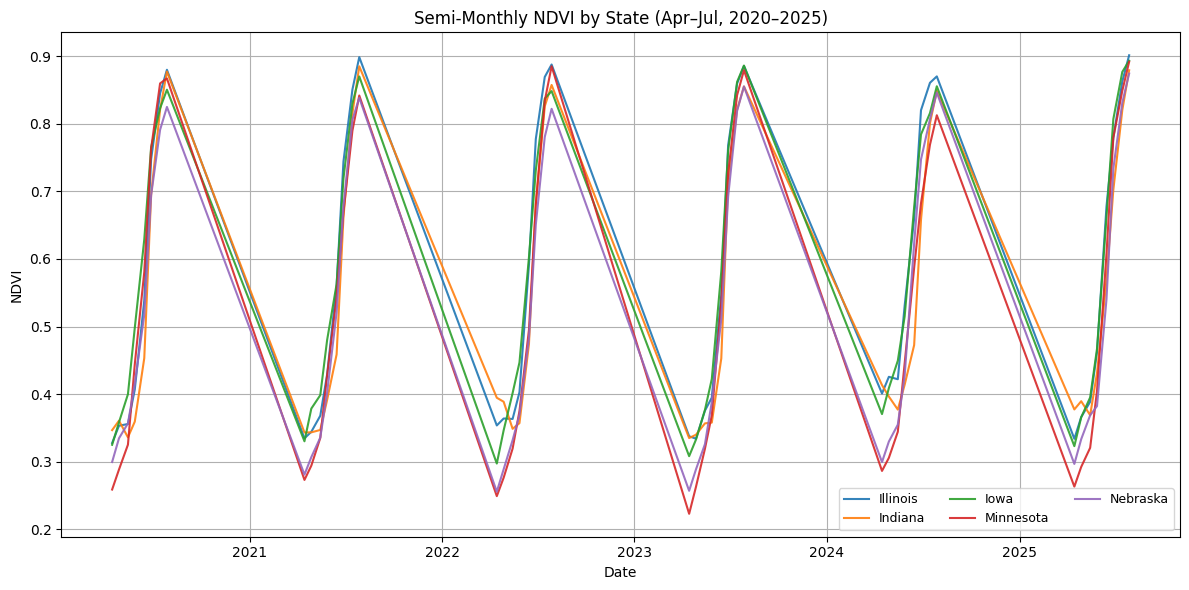

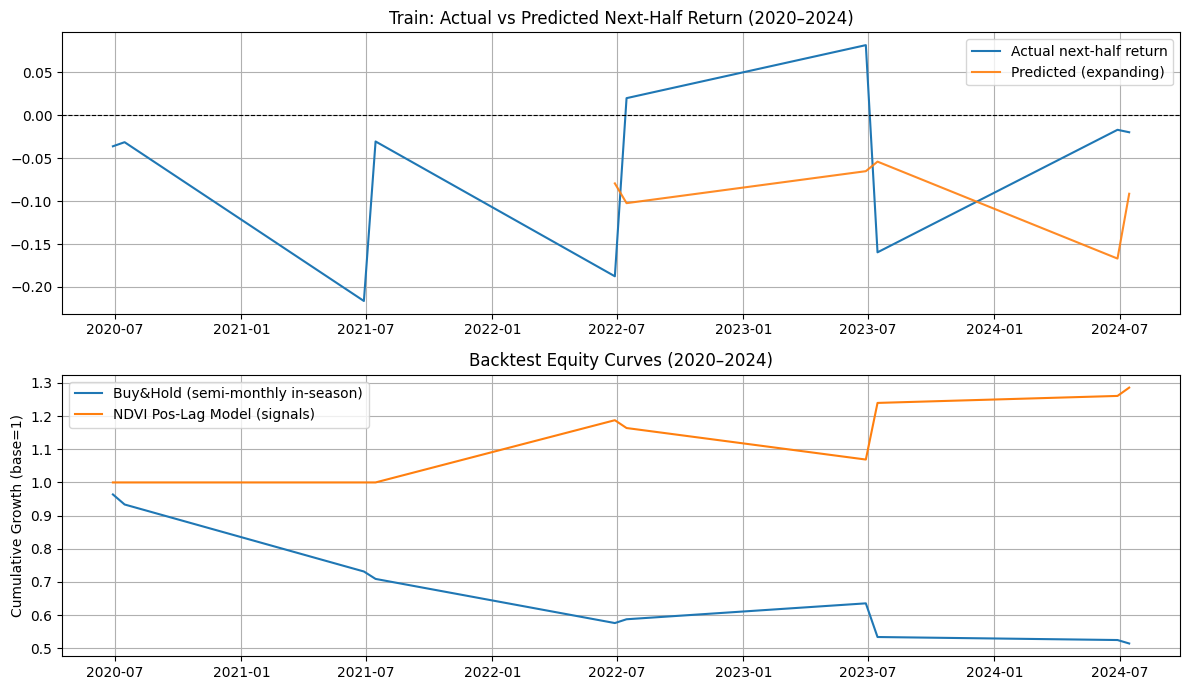


Saved: semimonth_ndvi_market_dataset.csv


In [32]:
!pip install -q earthengine-api pandas numpy scikit-learn yfinance matplotlib

import ee
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import pprint

PROJECT_ID = 'eloquent-figure-321013'
STATES = ['Iowa', 'Illinois', 'Nebraska', 'Minnesota', 'Indiana']
PTS_PER_STATE = 20
SCALE_MODIS = 250
SEASON_MONTHS = (4, 7)
POS_LAGS = list(range(0, 5))
MIN_TRAIN_STEPS = 4
SIGNAL_THRESH = 0.0015

try:
    ee.Initialize(project=PROJECT_ID)
except Exception:
    ee.Authenticate()
    ee.Initialize(project=PROJECT_ID)

today = datetime.date.today()
cur_year = today.year
YEARS_ALL = list(range(2020, min(2025, cur_year) + 1))
YEARS_TRAIN = [y for y in YEARS_ALL if 2020 <= y <= 2024]
print("Years (all):", YEARS_ALL, "| Train backtest:", YEARS_TRAIN)

us_states = ee.FeatureCollection('TIGER/2018/States')
cdl_year = '2022'
cdl = ee.ImageCollection('USDA/NASS/CDL').filterDate(f'{cdl_year}-01-01', f'{cdl_year}-12-31').first()
corn_mask = cdl.select('cropland').eq(1)

def sample_state_points(state_name):
    geom = us_states.filter(ee.Filter.eq('NAME', state_name)).first().geometry()
    pts = corn_mask.selfMask().stratifiedSample(numPoints=PTS_PER_STATE, region=geom, scale=30, geometries=True)
    return pts.map(lambda f: f.set('State', state_name))

pts_fc = ee.FeatureCollection(ee.List(STATES).map(sample_state_points)).flatten()
roi = pts_fc.geometry()

modis = ee.ImageCollection('MODIS/061/MOD13Q1').filterBounds(roi).filterDate('2020-01-01', '2025-12-31')

def prep_modis_image(img):
    ndvi = img.select('NDVI').multiply(0.0001)
    ndvi = ndvi.updateMask(ndvi.gte(-0.2)).updateMask(ndvi.lte(1.0))
    return ndvi.rename('NDVI').copyProperties(img, ['system:time_start'])

modis_ndvi = modis.map(prep_modis_image)

def calculate_per_image_state_means(img):
    samples = img.sampleRegions(collection=pts_fc, scale=SCALE_MODIS, geometries=False)
    grouped = samples.reduceColumns(
        reducer=ee.Reducer.mean().group(groupField=1, groupName='State'),
        selectors=['NDVI', 'State']
    )
    groups = ee.List(grouped.get('groups'))
    date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    return ee.FeatureCollection(groups.map(
        lambda g: ee.Feature(None, {
            'Date': date,
            'State': ee.Dictionary(g).get('State'),
            'NDVI': ee.Dictionary(g).get('mean')
        })
    ))

print("Computing per-image, per-state NDVI means (server-side)…")
fc = modis_ndvi.map(calculate_per_image_state_means).flatten()
size = int(fc.size().getInfo())
rows = [f['properties'] for f in fc.toList(size).getInfo()]
ndvi_df = pd.DataFrame(rows)

ndvi_df['Date'] = pd.to_datetime(ndvi_df['Date'])
ndvi_df['NDVI'] = pd.to_numeric(ndvi_df['NDVI'], errors='coerce')
ndvi_df['State'] = ndvi_df['State'].astype(str)
ndvi_df = ndvi_df[ndvi_df['Date'].dt.month.between(SEASON_MONTHS[0], SEASON_MONTHS[1])]

wide_16d = ndvi_df.pivot_table(index='Date', columns='State', values='NDVI', aggfunc='mean').sort_index()

weekly_list = []
for y in YEARS_ALL:
    wk_idx = pd.date_range(start=f'{y}-{SEASON_MONTHS[0]:02d}-01', end=f'{y}-{SEASON_MONTHS[1]:02d}-31', freq='W-FRI')
    g = wide_16d.loc[wide_16d.index.year == y]
    if g.empty:
        continue
    wk_vals = g.reindex(g.index.union(wk_idx)).sort_index().interpolate(method='time').reindex(wk_idx)
    wk_df = wk_vals.copy().reset_index(drop=False).rename(columns={'index': 'WeekEnd'})
    wk_df['Year'] = y
    weekly_list.append(wk_df)

if not weekly_list:
    raise SystemExit("No weekly NDVI after upsampling.")

weekly_ndvi = pd.concat(weekly_list, axis=0, ignore_index=True, sort=False)
if 'WeekEnd' not in weekly_ndvi.columns:
    weekly_ndvi = weekly_ndvi.reset_index().rename(columns={'index': 'WeekEnd'})

state_cols = [c for c in weekly_ndvi.columns if c in STATES]

def to_semimonthly(df, date_col='WeekEnd'):
    tmp = df.copy()
    tmp['Month'] = tmp[date_col].dt.month
    tmp['Half'] = np.where(tmp[date_col].dt.day <= 15, 1, 2)
    keep_cols = ['Year', 'Month', 'Half'] + state_cols
    sm = tmp[keep_cols].groupby(['Year', 'Month', 'Half'], as_index=False).mean()
    sm['NDVI_mean'] = sm[state_cols].mean(axis=1)
    return sm

sm_ndvi = to_semimonthly(weekly_ndvi)

start_yr = int(sm_ndvi['Year'].min())
mkt_raw = yf.download('ZC=F', start=f'{start_yr}-01-01', end=datetime.date.today(), progress=False, auto_adjust=True)

if mkt_raw is None or len(mkt_raw) == 0:
    raise SystemExit("No futures data downloaded for ZC=F.")

if isinstance(mkt_raw.columns, pd.MultiIndex):
    mkt_raw.columns = ['_'.join([str(x) for x in tup if x != '' and x is not None]) for tup in mkt_raw.columns]

if isinstance(mkt_raw, pd.Series):
    mkt_raw = mkt_raw.to_frame(name='Close')

price_col = None
plausible_price_cols = ['Close', 'Adj Close', 'close', 'adjclose', 'Adj_Close', 'Close_ZC=F', 'Adj Close_ZC=F']
for c in plausible_price_cols:
    if c in mkt_raw.columns:
        price_col = c
        break

if price_col is None:
    numeric_cols = [c for c in mkt_raw.columns if pd.api.types.is_numeric_dtype(mkt_raw[c])]
    if not numeric_cols:
        raise SystemExit(f"Could not find a price column in yfinance download. Columns: {list(mkt_raw.columns)}")
    price_col = numeric_cols[0]

mkt = mkt_raw[[price_col]].rename(columns={price_col: 'Close'})

dfc = mkt.copy()
dfc['Year'] = dfc.index.year
dfc['Month'] = dfc.index.month
dfc['Half'] = np.where(dfc.index.day <= 15, 1, 2)
dfc = dfc[dfc['Month'].between(SEASON_MONTHS[0], SEASON_MONTHS[1])]

mkt_sm = dfc.sort_index().groupby(['Year', 'Month', 'Half'], as_index=False)['Close'].last()
mkt_sm = mkt_sm.sort_values(['Year', 'Month', 'Half']).reset_index(drop=True)
mkt_sm['Ret'] = mkt_sm.groupby('Year')['Close'].pct_change()
mkt_sm['Target_Next'] = mkt_sm.groupby('Year')['Ret'].shift(-1)

for df_ in (sm_ndvi, mkt_sm):
    df_[['Year', 'Month', 'Half']] = df_[['Year', 'Month', 'Half']].astype(int)

data = pd.merge(sm_ndvi, mkt_sm, on=['Year', 'Month', 'Half'], how='inner')
data = data.sort_values(['Year', 'Month', 'Half']).reset_index(drop=True)

train_df = data[data['Year'].isin(YEARS_TRAIN)].copy()

def zscore_by_slot(train_data, full_data, cols):
    slot_stats = train_data.groupby(['Month', 'Half'])[cols].agg(['mean', 'std'])
    slot_stats.columns = ['_'.join(col).strip() for col in slot_stats.columns.values]
    out = full_data.copy()
    for c in cols:
        mu = slot_stats[f'{c}_mean']
        sd = slot_stats[f'{c}_std'].replace(0, np.nan)
        out[f'{c}_z'] = (out[c].values - out.set_index(['Month', 'Half']).index.map(mu).to_series().values) / \
                       (out.set_index(['Month', 'Half']).index.map(sd).to_series().values)
    return out

data_z = zscore_by_slot(train_df, data, state_cols)
data_z['z_mean'] = data_z[[f'{c}_z' for c in state_cols]].mean(axis=1)
data_z['dz_mean'] = data_z.groupby('Year')['z_mean'].diff()
data_z['dNDVI_mean'] = data_z.groupby('Year')['NDVI_mean'].diff()

def choose_positive_lag(df):
    base = df[df['Year'].isin(YEARS_TRAIN)].copy()
    cors = {}
    for L in POS_LAGS:
        dz_lag = base.groupby('Year')['dz_mean'].shift(L)
        c = dz_lag.corr(base['Target_Next'])
        cors[L] = np.nan if pd.isna(c) else float(c)
    chosen = sorted(cors.items(), key=lambda kv: (-abs(kv[1]) if kv[1] == kv[1] else -1, kv[0]))[0][0]
    return chosen, cors

lag_opt, lag_table = choose_positive_lag(data_z)
print("\n=== Positive-lag scan (dz_mean vs next-half return, train years) ===")
for L, v in lag_table.items():
    print(f"lag=+{L}: corr={v:+.3f}")
print(f"Chosen non-negative modeling lag: +{lag_opt}")

feat_cols = ['z_mean', 'dz_mean', 'dNDVI_mean']
X_all = data_z.groupby('Year')[feat_cols].shift(lag_opt)
y_all = data_z['Target_Next']

train_mask = data_z['Year'].isin(YEARS_TRAIN) & y_all.notna()
for c in feat_cols:
    train_mask &= X_all[c].notna()

X_tr = X_all.loc[train_mask].copy()
y_tr = y_all.loc[train_mask].copy()

dates_tr = pd.to_datetime(dict(
    year=data_z.loc[train_mask, 'Year'].values,
    month=data_z.loc[train_mask, 'Month'].values,
    day=np.where(data_z.loc[train_mask, 'Half'].values == 1, 15, 28)
))

pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value=0.0), Ridge(alpha=1.0))
pred_tr = pd.Series(index=X_tr.index, dtype=float)
start_i = max(MIN_TRAIN_STEPS, 1)

if len(X_tr) > start_i:
    for i in range(start_i, len(X_tr)):
        train_indices = X_tr.index[:i]
        predict_index = X_tr.index[i]
        pipe.fit(X_tr.loc[train_indices, :], y_tr.loc[train_indices])
        pred_tr.loc[predict_index] = pipe.predict(X_tr.loc[[predict_index], :])[0]

sig_tr = np.sign(pred_tr)
sig_tr = np.where(np.abs(pred_tr) >= SIGNAL_THRESH, sig_tr, 0.0)
ret_tr = sig_tr * y_tr

def equity_curve(r):
    return (1 + r.fillna(0)).cumprod()

valid_mask = ret_tr.notna()
eq_strat = equity_curve(ret_tr[valid_mask])
eq_bh = equity_curve(y_tr[valid_mask])

def calculate_performance(r, steps_per_year=8):
    r = np.nan_to_num(r, nan=0.0)
    n = len(r)
    ann = steps_per_year
    cagr = (np.prod(1 + r)**(ann / max(n, 1)) - 1) if n > 0 else np.nan
    vol = r.std(ddof=1) * np.sqrt(ann) if n > 1 else np.nan
    sharpe = (np.mean(r) * ann) / vol if (vol and vol > 0) else np.nan
    hit = (r > 0).mean() if n > 0 else np.nan
    eq = (1 + r).cumprod()
    mdd = float(np.min(eq / np.maximum.accumulate(eq) - 1)) if len(eq) > 0 else np.nan
    return {'CAGR': round(cagr, 3), 'Vol': round(vol, 3), 'Sharpe': round(sharpe, 3),
            'HitRate': round(hit, 3), 'MaxDD': round(mdd, 3)}

print("\n=== Backtest metrics (semi-monthly, 2020–2024) ===")
pprint.pprint({
    'Seasonal_BH': calculate_performance(y_tr.values),
    'NDVI_LagModel_PosOnly': calculate_performance(ret_tr.values),
})

mask_25 = (data_z['Year'] == 2025)
for c in feat_cols:
    mask_25 &= X_all[c].notna()

X_te25 = X_all.loc[mask_25].copy()
rows_25 = data_z.loc[mask_25, ['Year', 'Month', 'Half']].copy().reset_index(drop=True)
pred_25 = np.array([])

if len(X_te25) and np.any(pred_tr.notna()):
    use_fit = pred_tr.notna()
    pipe.fit(X_tr.loc[use_fit], y_tr.loc[use_fit])
    pred_25 = pipe.predict(X_te25)

if len(pred_25):
    if len(pred_25) != len(rows_25):
        raise RuntimeError(f"Prediction/row length mismatch: {len(pred_25)} vs {len(rows_25)}")
    rows_25['PredictedRet'] = pred_25
    sig_25 = np.sign(pred_25)
    sig_25 = np.where(np.abs(pred_25) >= SIGNAL_THRESH, sig_25, 0.0)
    rows_25['Signal'] = np.where(sig_25 > 0, 'Long', np.where(sig_25 < 0, 'Short', 'Flat'))

    print("\n=== 2025 Semi-Monthly Trade Suggestions (Apr–Jul) ===")
    print(rows_25.to_string(index=False, formatters={'PredictedRet': '{:+.3%}'.format}))
else:
    print("\nNo 2025 semi-monthly rows available after lag filtering or model not fitted.")


plt.figure(figsize=(12, 6))
for s in state_cols:
    sub = data_z[['Year', 'Month', 'Half', s]].dropna()
    sub = sub[sub['Month'].between(SEASON_MONTHS[0], SEASON_MONTHS[1])]
    sub['Date'] = pd.to_datetime(dict(year=sub['Year'], month=sub['Month'], day=np.where(sub['Half'] == 1, 15, 28)))
    plt.plot(sub['Date'], sub[s], label=s, alpha=0.9)
plt.title('Semi-Monthly NDVI by State (Apr–Jul, 2020–2025)')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 7))
ax1 = plt.subplot(2, 1, 1)
plt.plot(dates_tr, y_tr.values, label='Actual next-half return')
plt.plot(dates_tr, pred_tr.values, label='Predicted (expanding)', alpha=0.9)
plt.axhline(0, ls='--', c='k', lw=0.8)
plt.title('Train: Actual vs Predicted Next-Half Return (2020–2024)')
plt.legend()
plt.grid(True)

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(dates_tr[valid_mask.values], eq_bh.values, label='Buy&Hold (semi-monthly in-season)')
plt.plot(dates_tr[valid_mask.values], eq_strat.values, label='NDVI Pos-Lag Model (signals)')
plt.ylabel('Cumulative Growth (base=1)')
plt.title('Backtest Equity Curves (2020–2024)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

data_z.to_csv('semimonth_ndvi_market_dataset.csv', index=False)
print("\nSaved: semimonth_ndvi_market_dataset.csv")